1) Load Libraries and Data

In [1]:
import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

2) Data Exploration 

In [2]:
# Explore the data
print("\nInformation about the DataFrame:")
print(data.info())

print("\nSummary statistics of the DataFrame:")
print(data.describe(include='all'))

# Display the data types of each column
print("\nData types of each column:")
print(data.dtypes)


Information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329443 entries, 0 to 329442
Columns: 199 entries, country to weight
dtypes: float64(105), int64(65), object(29)
memory usage: 500.2+ MB
None

Summary statistics of the DataFrame:
       country           year      msna ADM2_PCODE ADM1_PCODE  \
count   329443  329443.000000    329443     107016     116498   
unique      19            NaN        41        630        132   
top        drc            NaN  drc-2023  NER004005     NER006   
freq     53671            NaN     40790       1274       4437   
mean       NaN    2022.116645       NaN        NaN        NaN   
std        NaN       0.784639       NaN        NaN        NaN   
min        NaN    2021.000000       NaN        NaN        NaN   
25%        NaN    2021.000000       NaN        NaN        NaN   
50%        NaN    2022.000000       NaN        NaN        NaN   
75%        NaN    2023.000000       NaN        NaN        NaN   
max        NaN    2023

3) Data Preparation and Feature Engineering

3.1 Drop columns not needed and those with too many NAs, filter NAs for response variable


Shape of the filtered DataFrame, without missing values for the response variable: (268511, 199)

DataFrame after keeping variables in vars_analysis:
<class 'pandas.core.frame.DataFrame'>
Index: 268511 entries, 0 to 329442
Data columns (total 99 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   water_source                             263014 non-null  object 
 1   shelter_type                             262333 non-null  object 
 2   lcsi_cat                                 169164 non-null  object 
 3   hoh_age                                  204282 non-null  float64
 4   child_adult_ratio                        264081 non-null  float64
 5   num_children                             268510 non-null  float64
 6   num_adults                               268505 non-null  float64
 7   children_0_2                             235209 non-null  float64
 8   children_3_5                

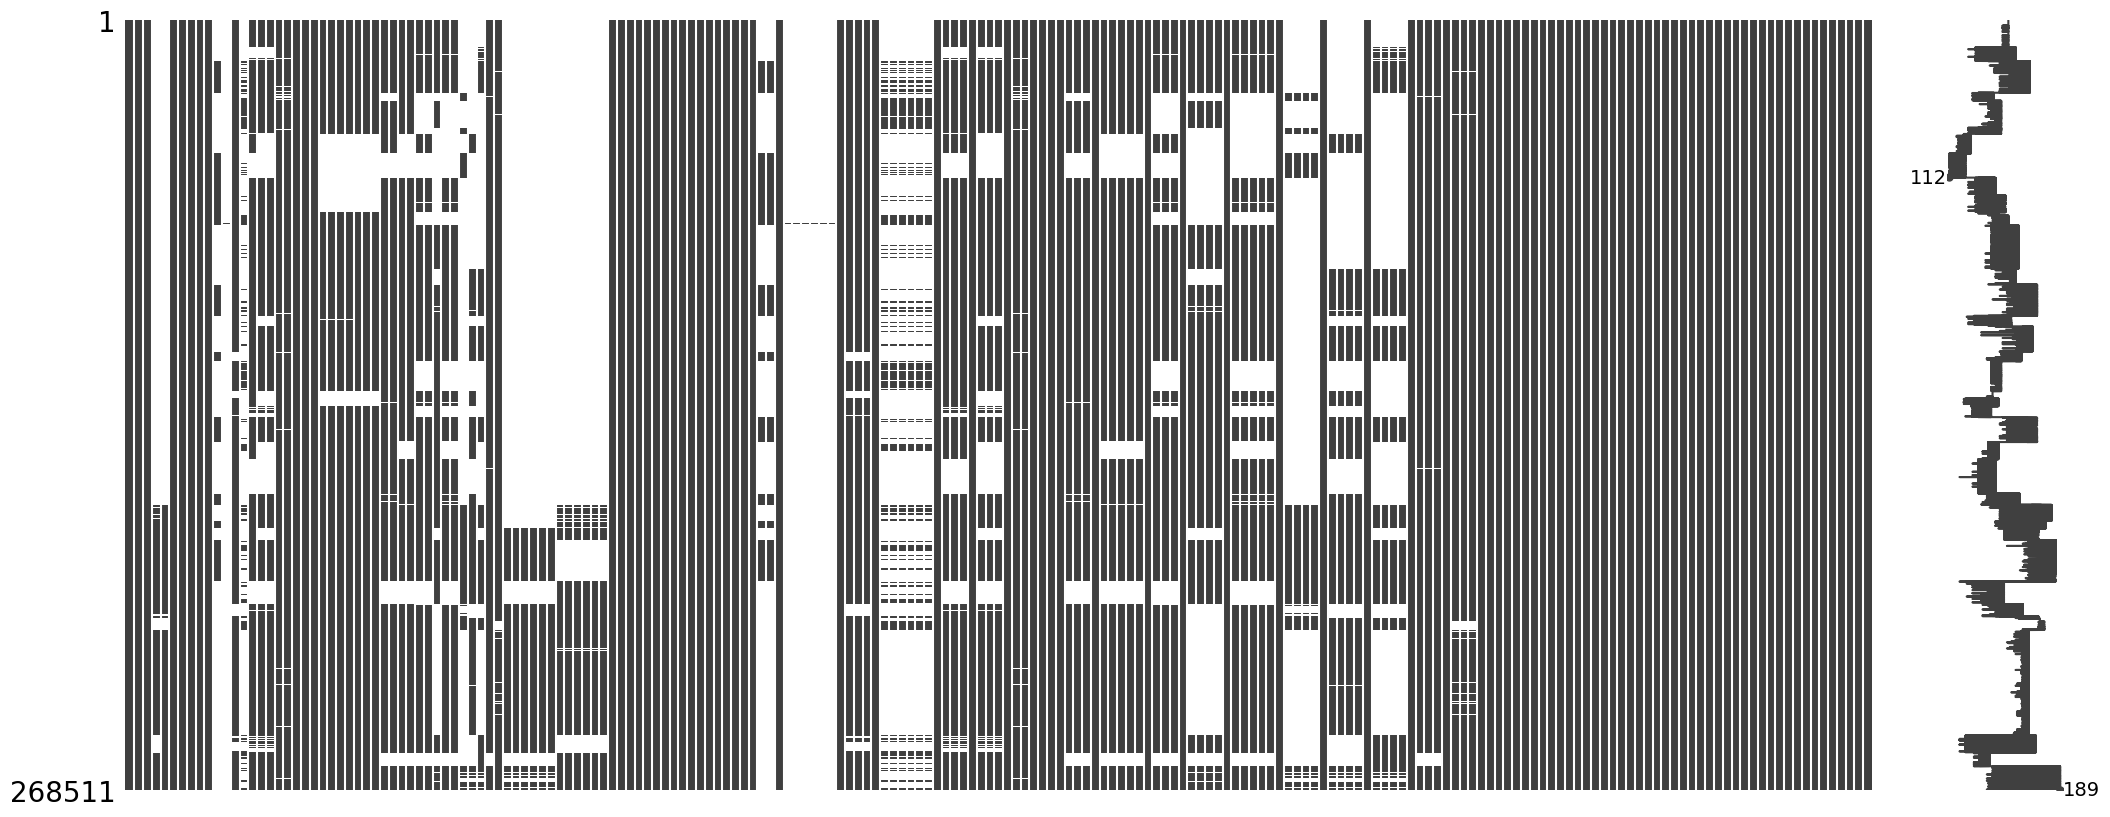

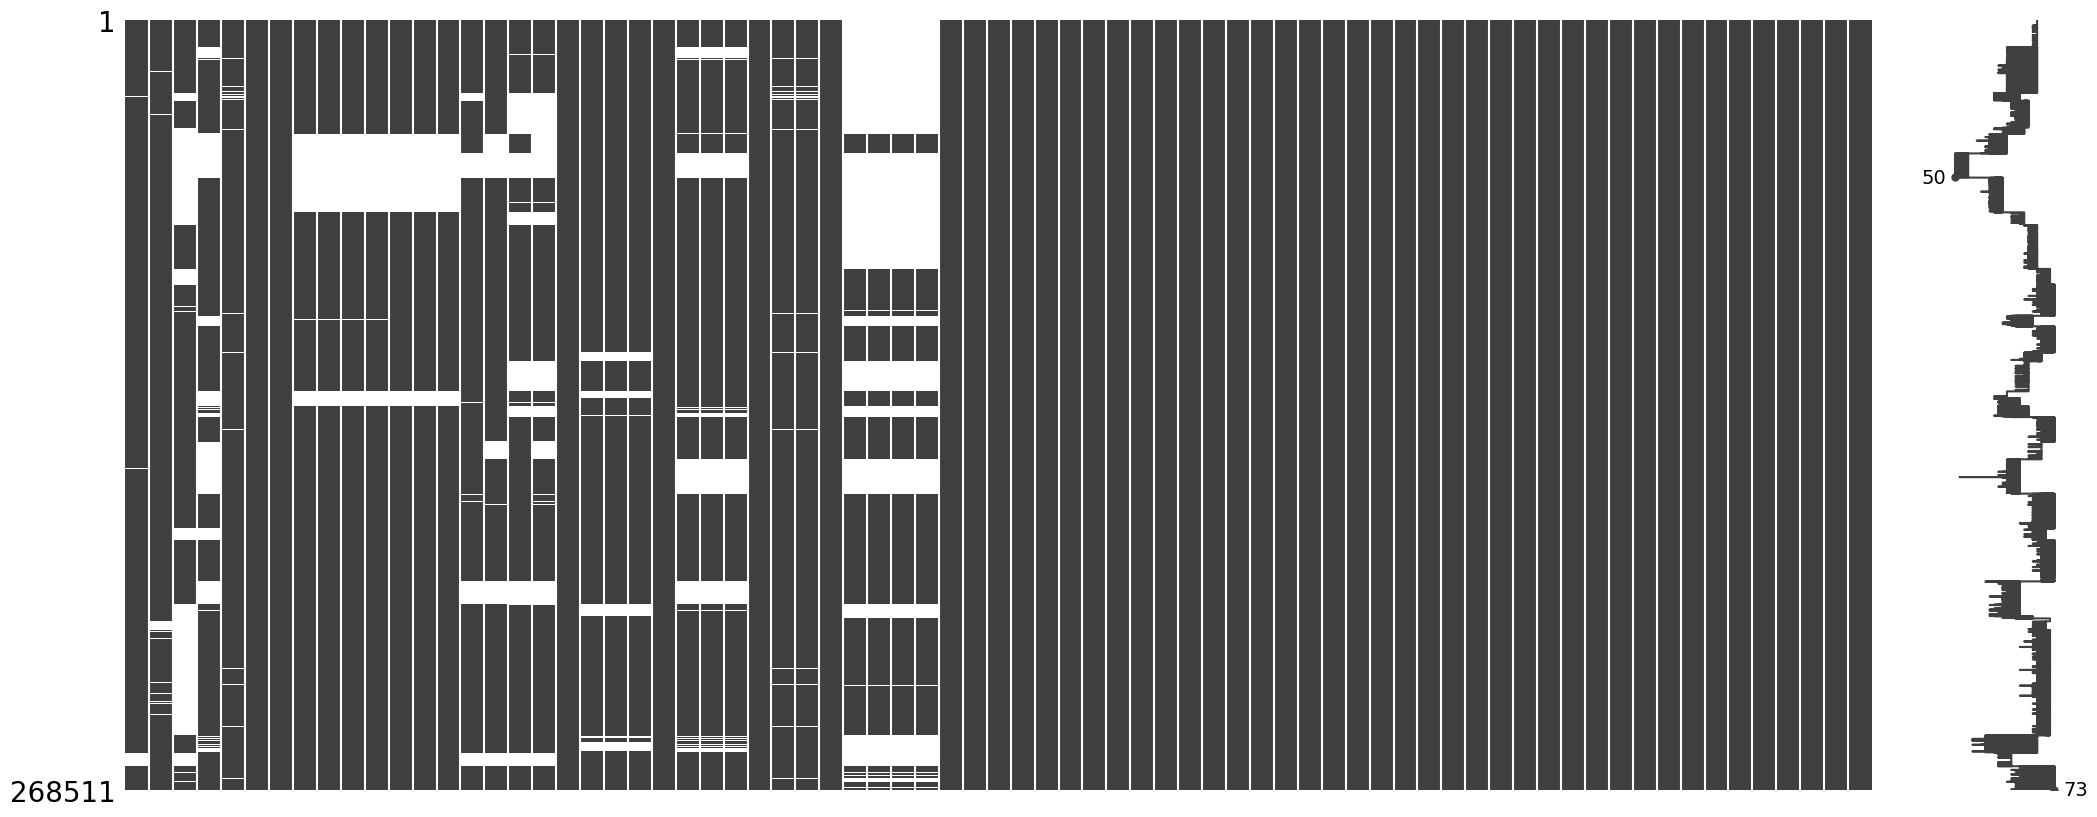


Final DataFrame after dropping unnecessary columns:
<class 'pandas.core.frame.DataFrame'>
Index: 268511 entries, 0 to 329442
Data columns (total 73 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   water_source                             263014 non-null  object 
 1   shelter_type                             262333 non-null  object 
 2   lcsi_cat                                 169164 non-null  object 
 3   hoh_age                                  204282 non-null  float64
 4   child_adult_ratio                        264081 non-null  float64
 5   num_children                             268510 non-null  float64
 6   num_adults                               268505 non-null  float64
 7   children_0_2                             235209 non-null  float64
 8   children_3_5                             235209 non-null  float64
 9   children_6_12                            235209 non-nul

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# Define function to display and drop columns based on a condition
def drop_columns_with_condition(df, condition, description):
    columns_to_drop = df.columns[condition].tolist()
    if columns_to_drop:
        print(f"\nDropped columns {description}:")
        print(columns_to_drop)
        return df.drop(columns=columns_to_drop)
    return df

# Filter out rows with missing values in the 'child_sep_severity' column
data_filtered = data.dropna(subset=['child_sep_severity'])
print("\nShape of the filtered DataFrame, without missing values for the response variable:", data_filtered.shape)

# Load variables to consider for the model
vars_analysis = pd.read_csv('vars_analysis.csv')['variable'].tolist()

# Select relevant columns
data_select = data_filtered[vars_analysis].copy()
print("\nDataFrame after keeping variables in vars_analysis:")
data_select.info()

# Identify columns with more than 50% missing values
missing_percentage = data_select.isnull().mean() * 100
columns_with_many_missing = missing_percentage > 50

# Drop columns with more than 50% missing values
data_select = drop_columns_with_condition(data_select, columns_with_many_missing, "with more than 50% missing values")

# Drop columns with zero variance (only one unique value)
zero_variance_condition = data_select.nunique() <= 1
data_select = drop_columns_with_condition(data_select, zero_variance_condition, "with zero variance")

# Identify and drop variables ending with '_NA' that have no other variable with the same stem
na_columns = [col for col in data_select.columns if col.endswith('_NA')]
stems = {col[:-3] for col in na_columns}
na_suffix_condition = [col for col in na_columns if not any(other_col.startswith(col[:-3]) and other_col != col for other_col in data_select.columns)]
data_select = drop_columns_with_condition(data_select, data_select.columns.isin(na_suffix_condition), "'_NA' with no matching stem variable")

# Assign the final cleaned data to data_select_na
data_select_na = data_select

# Visualize missing data matrix before dropping columns
msno.matrix(data_filtered)
plt.show()

# Visualize missing data matrix after dropping columns
msno.matrix(data_select_na)
plt.show()

# Display final DataFrame info
print("\nFinal DataFrame after dropping unnecessary columns:")
data_select_na.info()

# Check and display which variables from vars_analysis are no longer in the data
missing_vars = [var for var in vars_analysis if var not in data_select_na.columns]
print("\nVariables from vars_analysis no longer in the data:", missing_vars)


3.2 Change one-hot to label encoding for ordinal variables

In [4]:
# Load the new_labels CSV file
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])

print("\nLoaded new_labels DataFrame:")
print(new_labels.head())

# Create a copy of data_select_na to apply changes
data_ord = data_select_na.copy()

# Apply the label mapping to the data_ord DataFrame
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].fillna(pd.NA).astype('Int64')  # Fill NaNs with pd.NA before converting

# Check if recoded_variables are in data_ord
variables_in_data_ord = all(variable in data_ord.columns for variable in recoded_variables)
print(f"All recoded variables are in data_ord: {variables_in_data_ord}")

# Identify which variables are not in data_ord
missing_variables = [variable for variable in recoded_variables if variable not in data_ord.columns]
print(f"Variables not in data_ord: {missing_variables}")

# Display the first few rows of the recoded variables in the data_ord DataFrame
print("\nRecoded variables in data_ord DataFrame:")
print(data_ord[recoded_variables].head())

# Display the variable types of the recoded variables
print("\nVariable types of recoded variables:")
print(data_ord[recoded_variables].dtypes)


Loaded new_labels DataFrame:
       variable   label_old  label_new
0  shelter_type    adequate          1
1  shelter_type  inadequate          2
2  shelter_type  no_shelter          3
3  water_source    improved          1
4  water_source  unimproved          2


C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_1688\367835001.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_ord[variable] = data_ord[variable].replace(label_old, label_new)


All recoded variables are in data_ord: True
Variables not in data_ord: []

Recoded variables in data_ord DataFrame:
   shelter_type  water_source  lcsi_cat
0             1             1         1
1             1             1         1
3             1             1         2
4             1             1         1
6             1             2         3

Variable types of recoded variables:
shelter_type    Int64
water_source    Int64
lcsi_cat        Int64
dtype: object


3.4 Impute medians for NAs, as KNN takes too long to impute

In [5]:
# Impute medians for NAs for each variable
data_med = data_ord.fillna(data_ord.median())

# Verify that there are no missing values left
missing_values_count = data_med.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_values_count}")

Total missing values after imputation: 0


3.5 Standardize numerical data


Summary statistics before standardization:
       water_source  shelter_type  lcsi_cat        hoh_age  child_adult_ratio  \
count      268511.0      268511.0  268511.0  268511.000000      268511.000000   
mean       1.299504      1.233298  2.288744      42.719427           1.516010   
std        0.577049       0.44139  0.901305      11.218435           1.119179   
min             1.0           1.0       1.0       0.000000           0.035714   
25%             1.0           1.0       2.0      36.000000           0.666667   
50%             1.0           1.0       2.0      41.000000           1.333333   
75%             1.0           1.0       3.0      48.000000           2.000000   
max             3.0           3.0       4.0     114.000000          14.000000   

        num_children     num_adults   children_0_2   children_3_5  \
count  268511.000000  268511.000000  268511.000000  268511.000000   
mean        3.381534       2.726276       0.398527       0.564685   
std         2.07850

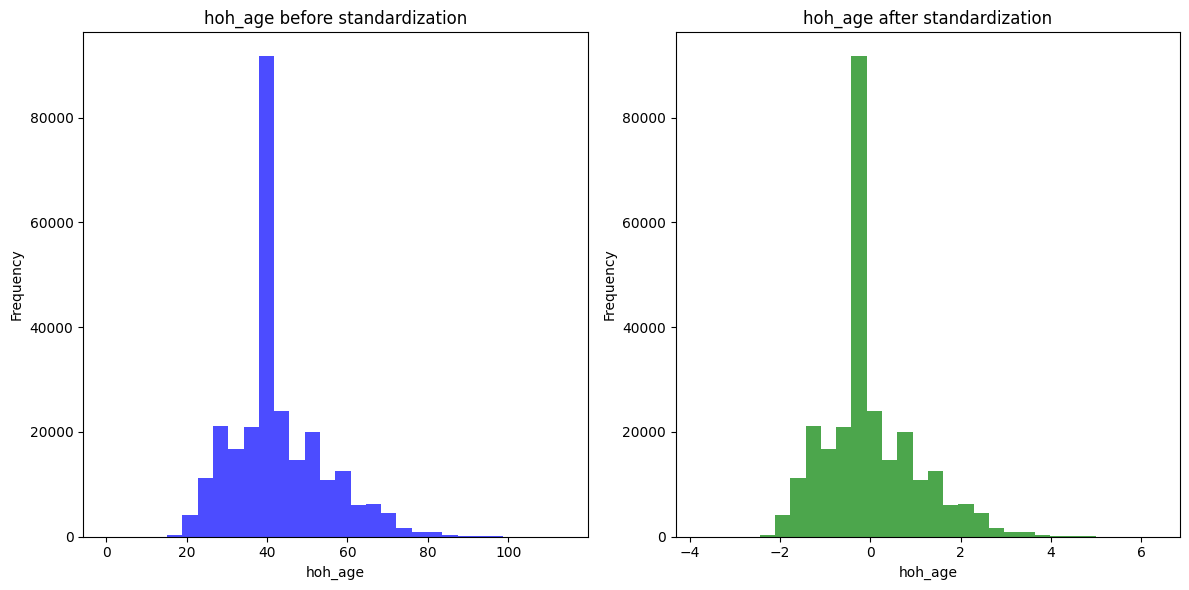

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load the vars_analysis.csv to identify variable types
vars_analysis = pd.read_csv('vars_analysis.csv', usecols=['variable', 'type'])
dummy_variables = vars_analysis[vars_analysis['type'] == 'dummy']['variable'].tolist()
categorical_variables = vars_analysis[vars_analysis['type'] == 'ordinal']['variable'].tolist()
numerical_variables = vars_analysis[vars_analysis['type'] == 'numerical']['variable'].tolist()

# Filter variables to include only those present in data_dum
dummy_variables = [var for var in dummy_variables if var in data_med.columns]
categorical_variables = [var for var in categorical_variables if var in data_med.columns]
numerical_variables = [var for var in numerical_variables if var in data_med.columns]

# Standardize the numerical variables (excluding dummy variables and categorical variables)
scaler = StandardScaler()
data_stand = data_med.copy()
data_stand[numerical_variables] = scaler.fit_transform(data_stand[numerical_variables])

# Add back the categorical variables without standardizing them
common_categorical_vars = list(set(categorical_variables).intersection(data_med.columns))
data_stand[common_categorical_vars] = data_med[common_categorical_vars]

# Display summary statistics before standardization
print("\nSummary statistics before standardization:")
print(data_med.describe())

# Display summary statistics after standardization
print("\nSummary statistics after standardization:")
print(data_stand.describe())

# Histogram for hoh_age before standardization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data_med['hoh_age'], bins=30, alpha=0.7, color='blue')
plt.title('hoh_age before standardization')
plt.xlabel('hoh_age')
plt.ylabel('Frequency')

# Histogram for hoh_age after standardization
plt.subplot(1, 2, 2)
plt.hist(data_stand['hoh_age'], bins=30, alpha=0.7, color='green')
plt.title('hoh_age after standardization')
plt.xlabel('hoh_age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

4. Feature Selection

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from boruta import BorutaPy
import shap

# Assuming data_stand is already defined and loaded

# Create a copy of data_stand for feature selection
data_fs = data_stand.copy()

# Separate features and target variable
X = data_fs.drop(columns=['child_sep_severity_family_reun_required'])
y = data_fs['child_sep_severity_family_reun_required']

### Convert All Variables to Float ###

# Force all features to float64
X = X.astype(np.float64)
y = y.astype(np.float64)

### Utility Functions for Checks ###

# Check if all columns are numeric
def check_numeric(df):
    if df.select_dtypes(include=[np.number]).shape[1] != df.shape[1]:
        raise ValueError("All features must be numeric. Please convert categorical variables to numeric format.")

# Check for missing values
def check_no_missing(df):
    if df.isnull().sum().sum() > 0:
        raise ValueError("Input data contains missing values. Please handle missing data before applying these methods.")

# Ensure target variable is binary or multiclass
def check_target(y):
    if not pd.api.types.is_numeric_dtype(y):
        raise ValueError("Target variable 'y' must be numeric.")
    if len(y.unique()) < 2:
        raise ValueError("Target variable 'y' must have at least two classes for classification.")

# Check if data is standardized and print variables that are not
def check_standardized(df, mean_threshold=0.01, std_threshold=0.01):
    # Calculate the absolute difference of means from 0 and standard deviations from 1
    mean_diff = df.mean().abs()  # Difference from 0 for means
    std_diff = (df.std() - 1).abs()  # Difference from 1 for standard deviations

    # Identify columns that are not standardized
    non_standardized_vars = df.columns[(mean_diff > mean_threshold) | (std_diff > std_threshold)].tolist()
    
    # Print warning only if there are non-standardized variables
    if non_standardized_vars:
        print("Warning: The following variables do not appear to be standardized (mean ≈ 0, std ≈ 1):")
        print(non_standardized_vars)

### 1. Ensure Input Data is Correct for Each Method ###

# Check target variable
check_target(y)

# Check if features are numeric and have no missing values
check_numeric(X)
check_no_missing(X)

### 2. Check Standardization for Methods Sensitive to Scale ###
check_standardized(X)

### 3. Recursive Feature Elimination (RFE) ###
try:
    print("Running RFE...")
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, n_features_to_select=10)
    X_rfe = rfe.fit_transform(X, y)
    print(f"Features after RFE: {X_rfe.shape[1]}")
except Exception as e:
    print(f"Error running RFE: {e}")

### 4. Feature Importance from Tree-Based Models ###
try:
    print("Running Random Forest...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features_rf = X.columns[indices[:10]]
    print(f"Top features according to Random Forest: {top_features_rf}")
except Exception as e:
    print(f"Error running Random Forest: {e}")

### 5. Elastic Net Regularization ###
try:
    print("Running Elastic Net...")
    elastic_net = ElasticNetCV(cv=5, random_state=42)
    elastic_net.fit(X, y)
    enet_coef = pd.Series(elastic_net.coef_, index=X.columns)
    top_features_enet = enet_coef[enet_coef != 0].index
    print(f"Top features according to Elastic Net: {top_features_enet}")
except Exception as e:
    print(f"Error running Elastic Net: {e}")

### 6. Boruta Algorithm ###
try:
    print("Running Boruta...")
    boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
    boruta_selector.fit(X.values, y)
    boruta_features = X.columns[boruta_selector.support_].tolist()
    print(f"Top features according to Boruta: {boruta_features}")
except Exception as e:
    print(f"Error running Boruta: {e}")

### 7. Mutual Information ###
try:
    print("Calculating Mutual Information...")
    mi = mutual_info_classif(X, y)
    mi_features = X.columns[np.argsort(mi)[-10:]].tolist()
    print(f"Top features according to Mutual Information: {mi_features}")
except Exception as e:
    print(f"Error calculating Mutual Information: {e}")

### Combine Results for the Most Relevant Features ###
try:
    combined_features = set(top_features_rf) | set(top_features_enet) | set(boruta_features) | set(mi_features)
    print(f"Combined selected features: {combined_features}")
except Exception as e:
    print(f"Error combining selected features: {e}")

### Drop Unselected Features ###

# Find the intersection of selected features from all methods
selected_features = list(combined_features)  # Convert set to list for indexing

# Filter the original dataset to keep only the selected features
X_selected = X[selected_features]

# Print the shape of the new dataset to confirm feature selection
print(f"Shape of data after dropping unselected features: {X_selected.shape}")

['water_source', 'shelter_type', 'lcsi_cat', 'displ_status_general_idp', 'displ_status_general_non_displaced', 'displ_status_general_refugee', 'displ_status_general_NA', 'hoh_gender_female', 'hoh_gender_male', 'hoh_gender_other', 'hoh_gender_NA', 'single_caregiver_no', 'single_caregiver_yes', 'single_caregiver_NA', 'received_assistance_6m_dnk', 'received_assistance_6m_dwta', 'received_assistance_6m_no', 'received_assistance_6m_yes', 'received_assistance_6m_NA', 'msna_afg-2021', 'msna_afg-2022', 'msna_bfa-2021', 'msna_bfa-2022', 'msna_bfa-2023', 'msna_bgd-hosts-2023', 'msna_bgd-refugees-2023', 'msna_bgd_hc-2021', 'msna_bgd_r-2021', 'msna_car-2021', 'msna_car-2022', 'msna_col-2022', 'msna_drc-2021', 'msna_drc-2022', 'msna_drc-2023', 'msna_hti-2022', 'msna_hti-admin1-2023', 'msna_irq-2021', 'msna_irq-2022', 'msna_ken-2022', 'msna_ken-2023', 'msna_lbn-2021', 'msna_lby-2021', 'msna_lby-2022', 'msna_mli-2023', 'msna_mmr-2022', 'msna_mmr-2023', 'msna_ner-2021', 'msna_ner-2022', 'msna_ner-2023

5. Data Splitting

In [9]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature set and y is your highly imbalanced response variable
# First, create a train + validation set and a test set (e.g., 80% train/validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

# Then, split the train + validation set into the actual training set and validation set (e.g., 75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# Result:
# - X_train, y_train: Training data (60% of the original dataset)
# - X_val, y_val: Validation data (20% of the original dataset)
# - X_test, y_test: Test data (20% of the original dataset)

# Print the structure of the resulting splits
print("Training Set")
print(f"  Features: {X_train.shape[1]}")
print(f"  Samples: {X_train.shape[0]}")
print(f"  Class 0: {np.sum(y_train == 0)}")
print(f"  Class 1: {np.sum(y_train == 1)}")
print("\nValidation Set")
print(f"  Features: {X_val.shape[1]}")
print(f"  Samples: {X_val.shape[0]}")
print(f"  Class 0: {np.sum(y_val == 0)}")
print(f"  Class 1: {np.sum(y_val == 1)}")
print("\nTest Set")
print(f"  Features: {X_test.shape[1]}")
print(f"  Samples: {X_test.shape[0]}")
print(f"  Class 0: {np.sum(y_test == 0)}")
print(f"  Class 1: {np.sum(y_test == 1)}")

Training Set
  Features: 25
  Samples: 161106
  Class 0: 160427
  Class 1: 679

Validation Set
  Features: 25
  Samples: 53702
  Class 0: 53475
  Class 1: 227

Test Set
  Features: 25
  Samples: 53703
  Class 0: 53476
  Class 1: 227


6. Data Balancing

SMOTE generates synthetic samples for the minority class (class 1) by interpolating between existing samples.
ENN (Edited Nearest Neighbors) undersamples the majority class by removing samples that are misclassified by their nearest neighbors.
SMOTEENN is a combination of both techniques. It first applies SMOTE to oversample the minority class, then uses ENN to clean up any overlapping regions between the classes, thereby reducing noise and improving the quality of the resampled dataset.

In [10]:
from imblearn.combine import SMOTEENN
from collections import Counter

# Apply SMOTE and ENN (Edited Nearest Neighbors) to balance the training data
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Display the new class distribution after balancing
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_train_resampled)}")


Original class distribution: Counter({0.0: 160427, 1.0: 679})
Resampled class distribution: Counter({1.0: 159997, 0.0: 155406})


7. Model selection and hyperparameter tuning

Logistic Regression: This model was selected as a baseline due to its simplicity and interpretability, providing a good starting point for binary classification. It is easy to implement and works well with linearly separable data. Additionally, with regularization (L1 or L2), it helps manage overfitting and feature selection.

Random Forest: Random Forest was chosen for its ability to handle both linear and non-linear relationships and its robustness against overfitting. It excels in scenarios with a mix of numerical and categorical features and can handle imbalanced datasets through class weighting. Its ensemble nature provides stability and reduces the variance of predictions.

XGBoost: XGBoost is known for its superior performance on structured/tabular data, making it a powerful choice for complex datasets. It uses gradient boosting, which allows it to correct errors sequentially, and is effective for both imbalanced and large datasets. Its built-in regularization, handling of missing values, and early stopping make it highly flexible for tuning and achieving high performance.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Define candidate models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(random_state=42)
}

# Define hyperparameters for GridSearch
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7]
    }
}

# Use GridSearchCV to find the best model and hyperparameters
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best params for {model_name}: {grid_search.best_params_}")


Tuning Random Forest...


### 8. Model Evaluation

We now evaluate the performance of multiple trained models on a **validation set** to understand how well they generalize to unseen data.

For each model:
- We use **ROC-AUC** to measure its ability to distinguish between positive and negative classes, which is crucial for imbalanced datasets.
- We calculate the **F1-Score** to assess the balance between precision and recall, providing insight into the model’s overall classification effectiveness.
- A **classification report** is generated to give detailed metrics, including precision, recall, and F1-score for both the majority and minority classes.

By comparing these metrics across models, we aim to select the one that performs best, generalizes well, and effectively handles class imbalance.


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report

for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name} on validation set:")
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:, 1]
    
    print(f"ROC-AUC: {roc_auc_score(y_val, y_val_prob)}")
    print(f"F1-Score: {f1_score(y_val, y_val_pred)}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred))


### 9. Model Retraining Summary

Once the best model is selected based on its performance on the validation set, we retrain it using the **full resampled training dataset** to take advantage of all the available data.

In this step:
- We identify the best model by comparing their **ROC-AUC** scores from the validation phase.
- The chosen model is then retrained using the entire **balanced training set**, which was resampled using techniques like **SMOTE + ENN** to address class imbalance.
- By using all the available training data, we ensure that the model has the maximum amount of information for learning, leading to better generalization during final testing.

This step prepares the model for its final evaluation on the test set.

In [ ]:
best_model_name = max(best_models, key=lambda name: roc_auc_score(y_val, best_models[name].predict_proba(X_val)[:, 1]))
best_model = best_models[best_model_name]

print(f"Retraining the best model: {best_model_name}...")
best_model.fit(X_train_resampled, y_train_resampled)